# Kalman Filter - 1D example

This notebook presents an example of a simplified Kalman filter. The filter includes obsevations for one dimentison (x) and velocity (v).

The Kalman filter derives its estimate of the current state based on predict and update cycle. 

In [1]:
import numpy as np

## Predict step

During the predict step, Kalman filter makes a prediction where will the state transition:

$x_{t}$ = F * $x_{t-1}$

Here F is the transition matrix that captures the dynamics of the prediction:
$$
F = \left(\begin{array}{cc} 
x & \Delta t\\ 
0 & v
\end{array}\right)
$$

And x captures the state:

$$
x = \left(\begin{array}{cc}x & v\end{array}\right)
$$

Example:

In [2]:
F = np.matrix([
    [1., 1.],
    [0., 1.]
])

## Update step


### Error calculation

The update step takes observations $(z)$ and calculate the error $(y)$. This error affects the prediction confidence $(P)$ and the state.
$$
z = \left(\begin{array}{cc} x_{meas} & v_{meas}\end{array}\right)
$$
$$
y = z - x_{t}
$$

Observations $z$ and the state $x$ might have different format / dimentionality. Therefore, to bring $x$ to the $z$ format we use observation matrix $H$. For example, if the observations $(z)$ provide only location measurement $(x$), then the observation matrix $(H)$ will have the following shape: 
$$
H = \left(\begin{array}{cc} 1 & 0\end{array}\right)
$$. 
On the other hand, if the observations provide both the location and the velocity, then we use the identity matrix: 
$$
H = \left(\begin{array}{cc} 
1 & 0 \\ 
0 & 1 
\end{array}\right)
$$.

$$y = z - H*x_{t}$$

In [3]:
H = np.identity(F.shape[0], dtype=F.dtype)

### Kalman Gain calculation

The next part is the update of the current state. The update of the current state takes the prediciton $(x_{t})$ and the error $(y)$. However, because the measurements might contain an error (for example the location measurement provided by GPS is never 100% precise), we only incorporate a portion of the error $(y)$ based on our confidence. This is achieved with the Kalman gain - $K$.

Kalman gain $(K)$ weighs in the confidence in our predictions $(P)$ vs. the confidence in the measurements $(R)$. Here $R$ is the measurement covariance. Normally $R$ is not really know. Therefore, $R$ is used as hyper-paramter allowing to control the strength of the filtering:

$$
K = P / (P + R) = P * (P + R)^{-1}
$$
Where $(P + R)^{-1}$ part is usually given a term $S$. $S$ does not carry any special meaning:
$$
S = P + R \\
K = P * S^{-1}
$$

Similarly to the transformations we applied to align $z$ and $x$, we use transition matrix $F$ to align $P$ and $S$:

$$
S = H*P*H_{T} + R \\
K = F*P*F_{T} * S^{-1}
$$

Here $H*P*H_{T}$ removes any potential covariances between diments, thus taking a strong assumpiton that the variables are independent. This assumption is a correct one. For example, if our state incorporates locaiton $x$ and velocity $v$, it is reasonable to assume that they are independent.

### State update
Once the Kalman gain $(K)$ was calculated, we can use it to update the current state:

$$
x_{t} = x_{t} + K*y
$$

### Prediciton Error update
To conclude the update, we will reevalute the prediction error - $P$ as follows:
$$
P = (1 - K) * P + Q
$$
Here $1$ is presented in the matrix format as an identity matrix - $I$:
$$
I = \left(\begin{array}{cc} 
1 & 0 \\ 
0 & 1
\end{array}\right)
$$

In [4]:
I = np.identity(F.shape[0], dtype=F.dtype)

And $Q$ is the the covariance of the prediction error $(y)$ - formal name is *process noise* or *motion covariance*: 
$$
Y = \left(\begin{array}{cc} y_{0} & y_{1} & ... & y_{n} \end{array}\right)\\
Q = 1/N * (Y - µ_{Y}) * (Y - µ_{Y})_{T}
$$

## Example

Set initial assumptions:

- x0 - current location assumption
- v0 - current speed / velocity assumption
- x_var0 - confidence in the initial location assumpiton - no impact on Kalman filter as long as initial value is high
- v_var0 - confidence in the initial speed / velocity assumpiton - no impact on Kalman filter as long as initial value is high
- x_measErr - location measurement noise
- v_measErr - velocity measuremnt noise

In [5]:
x0 = 0.0
v0 = 0.0
x_var0 = 100.0
v_var0 = 100.0
x_measErr = 1.5
v_measErr = 0.25

In [6]:
from observations import Observations
from covariance import CovarianceEstimator
from visualization import plot_results

In [7]:
o = Observations(decay=0.975, noise_x=x_measErr, noise_v=v_measErr)
covar = CovarianceEstimator(n_dim=F.shape[0], dtype=F.dtype)

Please note, as mentioned above the $R$ is not known and set as a hyper-parameter controlling the strength of the filtering.

In [8]:
x_t0 = np.matrix([x0, v0]).T
R = np.matrix(np.diag(np.array([10*x_measErr**2, 10*v_measErr**2])))
P = np.matrix(np.diag(np.array([x_var0, v_var0])))

In [9]:
results = dict(
    predictions = list(),
    pred_std = list(),
    observations = list()
)

for _ in range(100):

        # prediction step
        x_t1 = F * x_t0

        # update
        # - error
        z = np.matrix(o.get()).T
        y = z - H*x_t1

        results['predictions'].append(float(x_t1[0,0]))
        results['pred_std'].append(float(np.sqrt(P[0,0])))
        results['observations'].append(float(z[0,0]))

        # - Kalman gain
        # K = P / (P+R)
        S = H*P*H.T + R
        K = P*H.T * np.linalg.inv(S)

        # - state update
        # x[t] = x[t|t-1] * K*y
        x_t0 = x_t1 + K*y

        # - prediction error update
        # P = (1-K)*P
        P = (I - K*H)*P
        # P = P + Q
        Q = covar.eval(y)
        P = F*P*F.T + Q

### Plot 1 - Observations vs Predicitons

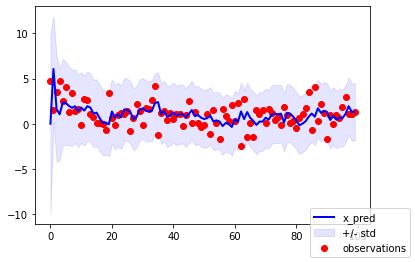

In [10]:
plot_results(**results, file_name=None)